# **Análise de Série Temporal de Temperaturas**

Neste trabalho, iremos estudar dados de séries temporais de temperatura de cidades brasileiras (capitais). Observaremos se existe a possibilidade de realizarmos previsões em cima destes dados.

Nossa hipótese: dados relativos ao El Niño (fenômeno que ocorre no oceâno pacífico) podem ser utilizados para criar features úteis na hora de realizarmos as previsões de temperatura de cidades brasileiras.

## **Bibliotecas utilizadas**

In [1]:
import numpy
import cdsapi
import pandas
import cfgrib
import tqdm

import xarray as xr
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

sns.set()

## **Conectando com a API de dados**

Para este trabalho, utilizaremos os dados obtidos pela API da plataforma [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/). Essa plataforma é grátis para utilização, e é um grande repositório de dados referentes a meteorologia no mundo inteiro. 

Considerando o escopo do nosso projeto, iremos utilizar dados da base de dados [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview). A metodologia ERA5 fornece estimativas por hora para uma grande quantidade de variáveis atmosféricas, oceânicas, e da superfície terrestre. As informações contidas nessa base são de todos os dias, de 1940 até 2023, obtidas para todo o mundo, em intervalos de latitude e longitude de 25 minutos (em coordenadas). 

Como estamos interessados em estudar a temperatura superficial, iremos requisitar referente a seguinte variável armazenada na plataforma: 2m temperature. Este parâmetro é a temperatura do ar a 2 metros acima da superfície terrestre, mar ou águas interiores. A temperatura a 2 metros é calculada interpolando entre o nível do modelo mais baixo e a superfície da Terra, levando em consideração as condições atmosféricas. Este parâmetro tem unidades de kelvin (K). A temperatura medida em kelvin pode ser convertida para graus Celsius (°C) subtraindo 273,15.

In [5]:
def fetch_cdsapi_data(coordinates: list[int], time: list[int], years: list[int], months: list[int], days: list[int], filename: str):
    days = [str(i).zfill(2) for i in days]
    months = [str(i).zfill(2) for i in months]
    years = [str(i) for i in years]
    time = [str(i).zfill(2) + ':00' for i in time]
    area =  coordinates  # North, East, South, West
    
    c = cdsapi.Client()

    api_dict = {
        'product_type': 'reanalysis',
        'format': 'grib',
        'month': months,
        'year': years,
        'day': days,
        'time': time,
        'variable': '2m_temperature',
        'area': area
    }

    c.retrieve('reanalysis-era5-single-levels', api_dict, filename)

### **Valores padrões para extração dos dados**

Para nossa análise, iremos considerar dados referentes a todos os todos os meses, todos os dias, sobre as horas 00:00, 04:00, 08:00, 12:00, 16:00, 20:00, entre os anos de 2000 e 2022.

In [6]:
days = list(range(1, 32))
months = list(range(1, 13))
years = list(range(2000, 2023))
time = list(range(0, 24, 4))

## **Obtendo dados das cidades brasileiras**

### **São Paulo**

In [30]:
region_coordinates = [-23, -47, -24, -46]
fetch_cdsapi_data(region_coordinates, time, years, months, days, 'sao_paulo.grib')

2023-11-26 23:40:02,060 INFO Welcome to the CDS
2023-11-26 23:40:02,060 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-26 23:40:02,466 INFO Request is completed
2023-11-26 23:40:02,467 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data1/adaptor.mars.internal-1701038380.2623334-13267-14-eae9f95c-541f-4132-9e75-ac1ee6589e25.grib to sao_paulo.grib (11.5M)
2023-11-26 23:40:10,620 INFO Download rate 1.4M/s   


### **Rio de Janeiro**

In [40]:
region_coordinates = [-22.5, -44, -23.25, -42.25]
fetch_cdsapi_data(region_coordinates, time, years, months, days, 'rio_de_janeiro.grib')

2023-11-27 12:43:56,618 INFO Welcome to the CDS
2023-11-27 12:43:56,619 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-27 12:43:56,978 INFO Request is completed
2023-11-27 12:43:56,979 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data6/adaptor.mars.internal-1701070807.501021-8063-8-94ef1f5e-4842-4352-a366-98c6e7ca9c08.grib to rio_de_janeiro.grib (11.5M)
2023-11-27 12:44:10,656 INFO Download rate 863.8K/s 


### **Salvador**

In [32]:
region_coordinates = [-12.75, -38.75, -13.25, -38.25]
fetch_cdsapi_data(region_coordinates, time, years, months, days, 'salvador.grib')

2023-11-27 05:30:34,324 INFO Welcome to the CDS
2023-11-27 05:30:34,324 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-27 05:30:34,633 INFO Request is queued
2023-11-27 05:59:09,475 INFO Request is running
2023-11-27 06:37:30,911 INFO Request is completed
2023-11-27 06:37:30,911 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data3/adaptor.mars.internal-1701075306.2175608-9476-7-48ce4fb0-bc4c-4264-9397-0f9475720717.grib to salvador.grib (11.5M)
2023-11-27 06:37:47,230 INFO Download rate 724K/s   


### **Manaus**

In [34]:
region_coordinates = [-2.75, -60.25, -3.25, -59.75]
fetch_cdsapi_data(region_coordinates, time, years, months, days, 'manaus.grib')

2023-11-27 07:35:31,265 INFO Welcome to the CDS
2023-11-27 07:35:31,266 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-27 07:35:31,527 INFO Request is queued
2023-11-27 07:47:57,262 INFO Request is running
2023-11-27 08:28:19,872 INFO Request is completed
2023-11-27 08:28:19,872 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data6/adaptor.mars.internal-1701081831.8225987-12955-11-1765d9c1-1ee7-433a-93f9-8b2d1bb7c21c.grib to manaus.grib (11.5M)
2023-11-27 08:28:34,888 INFO Download rate 786.8K/s 


### **Macapá**

In [35]:
region_coordinates = [0.4, -51.57, -0.36, -50.58]
fetch_cdsapi_data(region_coordinates, time, years, months, days, 'macapa.grib')

2023-11-27 08:28:35,367 INFO Welcome to the CDS
2023-11-27 08:28:35,368 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-27 08:28:35,683 INFO Request is queued
2023-11-27 08:32:56,928 INFO Request is running
2023-11-27 09:11:18,386 INFO Request is completed
2023-11-27 09:11:18,386 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data2/adaptor.mars.internal-1701084482.3821383-22159-12-793ff93d-a0fe-4f52-ba4c-25b252a435bc.grib to macapa.grib (11.5M)
2023-11-27 09:11:26,544 INFO Download rate 1.4M/s   


### **João Pessoa**

In [36]:
region_coordinates = [-7, -35, -7.25, -34.75]
fetch_cdsapi_data(region_coordinates, time, years, months, days, 'joao_pessoa.grib')

2023-11-27 09:11:27,030 INFO Welcome to the CDS
2023-11-27 09:11:27,031 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-27 09:11:27,519 INFO Request is queued
2023-11-27 09:19:50,935 INFO Request is running
2023-11-27 10:00:13,677 INFO Request is completed
2023-11-27 10:00:13,678 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data5/adaptor.mars.internal-1701087336.9819942-18397-7-cec454dd-ab32-4236-90c3-ce15a4a57159.grib to joao_pessoa.grib (5.8M)
2023-11-27 10:00:26,828 INFO Download rate 449.2K/s 


### **Porto Alegre**

In [37]:
region_coordinates = [-29.45, -51.98, -30.59, -50.67]
fetch_cdsapi_data(region_coordinates, time, years, months, days, 'porto_alegre.grib')

2023-11-27 10:00:27,301 INFO Welcome to the CDS
2023-11-27 10:00:27,302 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-27 10:00:27,540 INFO Request is queued
2023-11-27 10:02:23,182 INFO Request is running
2023-11-27 10:43:10,163 INFO Request is completed
2023-11-27 10:43:10,164 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data5/adaptor.mars.internal-1701089924.0188954-6575-4-62976ab0-a5a5-4847-9bc6-bc3e079acba2.grib to porto_alegre.grib (11.5M)
2023-11-27 10:43:18,190 INFO Download rate 1.4M/s   


### **Campo Grande**

In [38]:
region_coordinates = [-20.25, -54.75, -20.75, -54.5]
fetch_cdsapi_data(region_coordinates, time, years, months, days, 'campo_grande.grib')

2023-11-27 10:43:18,662 INFO Welcome to the CDS
2023-11-27 10:43:18,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-27 10:43:19,107 INFO Request is queued
2023-11-27 10:46:12,676 INFO Request is running
2023-11-27 11:26:01,971 INFO Request is completed
2023-11-27 11:26:01,972 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data0/adaptor.mars.internal-1701092511.9705138-17328-7-f4787ef9-a9c3-4fea-9582-0b4c2c5656f5.grib to campo_grande.grib (5.8M)
2023-11-27 11:26:10,962 INFO Download rate 657.1K/s 


### **Brasília**

In [39]:
region_coordinates = [-15.5, -48.5, -16.25, -47.25]
fetch_cdsapi_data(region_coordinates, time, years, months, days, 'brasilia.grib')

2023-11-27 11:26:11,437 INFO Welcome to the CDS
2023-11-27 11:26:11,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-27 11:26:11,726 INFO Request is queued
2023-11-27 11:29:05,300 INFO Request is running
2023-11-27 12:10:55,678 INFO Request is completed
2023-11-27 12:10:55,679 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data1/adaptor.mars.internal-1701095078.8183043-27229-7-3092302c-c2cf-45a6-a92d-87f360057108.grib to brasilia.grib (11.5M)
2023-11-27 12:11:12,538 INFO Download rate 700.8K/s 


## **Análises de Séries Temporais**

Nesta seção, iremos realizar a análise da série temporal recolhida da API. Para isso, iremos considerar as seguintes análises, feitas sobre um dos datasets recolhidos (iremos escolher o dataset de São Paulo para realizar as análises, e assumiremos que os outros seguem de propriedades similares):
- Agrupamento diário de temperatura.
- Agrupamento por mês de temperatura.

Para cada uma destas análises, iremos extrair informações e métricas relevantes sobre dados temporais/sequencias, como estacionariedade, sazonalidade, etc. Para isso, será feita a utilização de bibliotecas estatísticas como *statsmodels*.

### **Pré-procesamento**

In [92]:
dataset = xr.open_dataset('./data/sao_paulo.grib', engine='cfgrib')

In [93]:
def dataset_pre_processing(dataset: xr.Dataset, group_type: str = '1D', filter_coordinates: tuple[float, float] | None = None, eps: float = 1e-2) -> pandas.DataFrame:
    dataset_temperatures = dataset['t2m']
    
    if filter_coordinates is not None:
        assert isinstance(filter_coordinates, tuple) & len(filter_coordinates) == 2, 'Filter coordinates must be tuple with two coordinates values.'

        lat, long = filter_coordinates
        dataset_temperatures = dataset_temperatures.where((dataset_temperatures.latitude - lat < eps) & (dataset_temperatures.longitude - long < eps))
    
    dataframe = dataset_temperatures.to_dataframe()
    dataframe = dataframe[dataframe['t2m'].notna()].reset_index()

    assert group_type in ('1D', '1M'), 'Group type must be in 1D or 1M to group by for daily or monthly temperatures.'

    mean_temperatures_dataframe = dataframe.groupby(pandas.Grouper(key='time', freq=group_type)).mean()

    return mean_temperatures_dataframe

In [94]:
time_series_daily = dataset_pre_processing(dataset, group_type='1D')
time_series_monthly = dataset_pre_processing(dataset, group_type='1M')

### **Análise de Trend, Sazonalidade e Residual**

Utilizando *seasonal_decompose* da statsmodels, iremos decompor nossa série temporal de temperaturas diárias e mês a mês, observando se existe uma possível decomposição em componentes de sazonalidade e tendência, com erros/residuais associados.

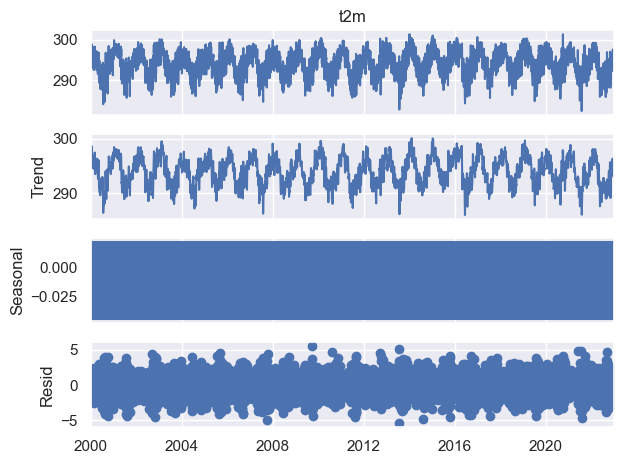

In [10]:
decomposition = sm.tsa.seasonal_decompose(time_series_daily['t2m'], model='additive')
decomposition.plot()
plt.show()

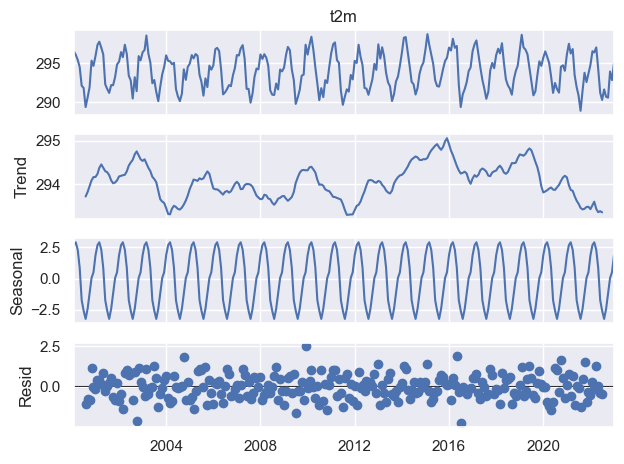

In [11]:
decomposition = sm.tsa.seasonal_decompose(time_series_monthly['t2m'], model='additive')
decomposition.plot()
plt.show()

Como é possível observar, os dados na granularidade diárias são mais complexos, indicando uma oscilação alta como vista na componente sazonal. Enquanto isso, a granularidade maior, de temperaturas mês a mês são decompostas em componentes mais claras de se visualizar. 

Podemos seguir nossas análises para ambos os caminhos, mas a predição mensal se torna mais plausível.

## **Teste de estacionariedade**

Podemos agora calcular métricas relativas a estacionariedade das séries temporais de temperaturas. Uma série estacionária possui propriedades estatísticas (média, variância e autocovariância) que não se alteram ao longo do tempo. Se a média e variância da série temporal são constantes e a autocovariância (covariância entre as observações em diferentes *timestamps*) depende apenas da distância entre as observações e não do instante de tempo em que ocorreu, a série temporal pode ser considerada estacionária.

Essa métrica é de extrema importância para determinar se podemos utilizar alguns modelos estatísticos de série temporal e de auto-regressão. Podemos aplicar o teste aumentado de Dick-Fuller para calcular o p-value referente a estacionariedade da série: se este valor for muito baixo (inferior a 0.05 - 5%), temos fortes indicativos de que a série é estacionária.

In [12]:
result = sm.tsa.stattools.adfuller(time_series_daily.t2m)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -7.085403355507169
p-value: 4.5522419443501003e-10
Critical Values:
	1%: -3.4311306784190343
	5%: -2.8618850060724674
	10%: -2.5669536418716876


In [13]:
result = sm.tsa.stattools.adfuller(time_series_monthly.t2m)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -3.1067765977691306
p-value: 0.026055737616116955
Critical Values:
	1%: -3.4557539868570775
	5%: -2.8727214497041422
	10%: -2.572728476331361


Podemos observar que para ambas as séries temporais (temperaturas diárias e mensais), o tesde de Dickey-Fuller retornou p-valores menores do que 0.05, indicando estacionariedade.

### **ACF e PACF**

Agora, considerando que as séries são estacionarias, podemos estudar quantas lags (informações prévias de cada timestamp) podem ser utilizadas para prever a temperatura atual. As métricas ACF e PACF servem justamente para indicar a correlação existente (direta e indiretamente) de um dado passado no resultado observado no presente (o quanto a temperatura de ontem impacta na temperatura de hoje, o quanto a temperatura de anteontem impacta na temperatura de hoje, etc).

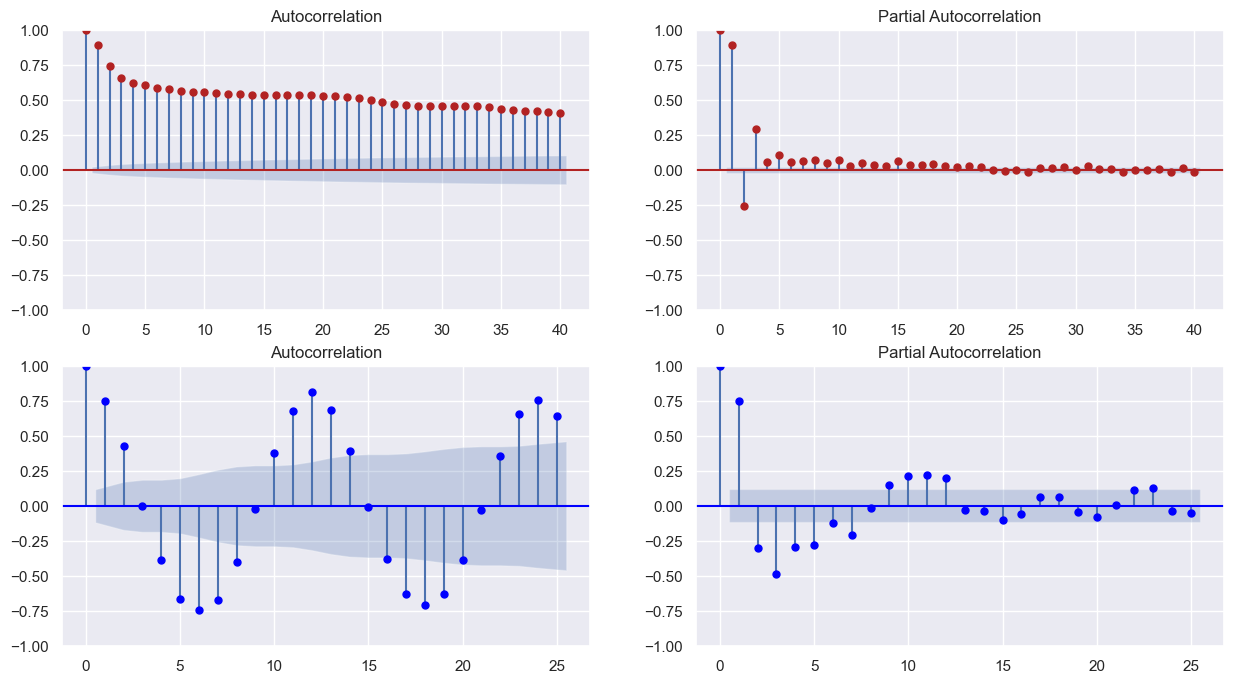

In [14]:
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(time_series_daily.t2m, ax=ax1,color ='firebrick')

ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(time_series_daily.t2m, ax=ax2,color='firebrick')

ax3 = fig.add_subplot(223)
fig = sm.graphics.tsa.plot_acf(time_series_monthly.t2m, ax=ax3,color ='blue')

ax4 = fig.add_subplot(224)
fig = sm.graphics.tsa.plot_pacf(time_series_monthly.t2m, ax=ax4,color='blue')

plt.show()

Podemos observar que quanto mais nos afastamos do presente, menor relevância/contribuição aquele dado tem para a previsão da temperatura do dia de hoje. Para a série histórica de temperatura mensal, existe uma autocorrelação ainda alta até uma lag de 25 timestamps, mas quando analisamos a autocorrelação parcial, observamos que ela decai já antes de 15 timestamps. O mesmo acontece para a série de temperatura diária, em que a autocorrelação parcial próxima de 5 timestamps de lag já é drasticamente reduzida.

## **Aplicando Machine Learning na previsão de temperatura**

Uma vez com os dados recolhidos e análises feitas sobre as séries temporais, iremos aplicar um estudo de aprendizado de máquina, com objetivo de realizar regressão/previsão do valor de temperatura, considerando unicamente a série histórica de temperaturas da região. 

### **Construção do dataset**

Para esta tarefas, iremos considerar os dois conjuntos de dados: séries históricas de temperaturas diárias e mensais. Além disso, iremos construir datasets com diferentes lags, observando os resultados obtidos quando treinamos nosso conjunto em diferentes configurações.

#### **Configuração do dataset**

* **Lags:** iremos construir datasets diferentes com lags de 5, 10, 15 timestamps (dias/meses)
* **Dataset de treino, validação e teste:** iremos construir o dataset de treino e validação. O treino irá corresponder a 98% do nosso conjunto de dados e 2% do conjunto será de validação.

In [2]:
def create_lagged_list(time_series: numpy.array, timestamp: numpy.array, lag):
    lagged_target = []
    lagged_timestamp = []
    lagged_data = []
    for i in range(lag + 1, len(timestamp)):
        lagged_data.append(time_series[i-lag - 1: i - 1])
        lagged_target.append(time_series[i])
        lagged_timestamp.append(timestamp[i])
    
    return lagged_target, lagged_timestamp, lagged_data

In [3]:
def create_dataset(dataframe: pandas.DataFrame, validation_split: float = 0.1, lag: int = 5) -> tuple[pandas.DataFrame, pandas.DataFrame]:
    timestamp = dataframe.time.dt.date.values
    time_series = dataframe.t2m.values

    lagged_target, lagged_timestamp, lagged_data = create_lagged_list(time_series, timestamp, lag=lag)
    
    max_id = int(len(lagged_timestamp) * (1 - validation_split))
    
    train_target = numpy.array(lagged_target[:max_id])
    train_time_series = numpy.array(lagged_data[:max_id])
    train_timestamp = numpy.array(lagged_timestamp[:max_id])
    
    validation_target = numpy.array(lagged_target[max_id:])
    validation_time_series = numpy.array(lagged_data[max_id:])
    validation_timestamp = numpy.array(lagged_timestamp[max_id:])

    return {
        'train': {
            'time_series': train_time_series,
            'target': train_target,
            'timestamp': train_timestamp
        },
        'val': {
            'time_series': validation_time_series,
            'target': validation_target,
            'timestamp': validation_timestamp
        }
    }

In [95]:
daily_lag_5_dataset = create_dataset(time_series_daily.reset_index(), lag=5, validation_split=0.2)
daily_lag_10_dataset = create_dataset(time_series_daily.reset_index(), lag=10, validation_split=0.2)
daily_lag_15_dataset = create_dataset(time_series_daily.reset_index(), lag=15, validation_split=0.2)

montly_lag_5_dataset = create_dataset(time_series_monthly.reset_index(), lag=5, validation_split=0.2)
montly_lag_10_dataset = create_dataset(time_series_monthly.reset_index(), lag=10, validation_split=0.2)
montly_lag_15_dataset = create_dataset(time_series_monthly.reset_index(), lag=15, validation_split=0.2)

### **Random Forest Regressor**

In [102]:
grid_space = {'max_depth': [5, 10], 'n_estimators': [100, 500]}
random_forest = RandomForestRegressor()
grid = GridSearchCV(random_forest, param_grid=grid_space, scoring='r2')

In [103]:
dataset_config = {'d-5': daily_lag_5_dataset, 'd-10': daily_lag_10_dataset, 'd-15': daily_lag_15_dataset, 'm-5': montly_lag_5_dataset, 'm-10': montly_lag_10_dataset, 'm-15': montly_lag_15_dataset}
results = {}
for dataset_name, dataset in dataset_config.items():
    model_grid = grid.fit(dataset['train']['time_series'], dataset['train']['target'])
    results[dataset_name] = {'best_params': model_grid.best_params_, 'best_score': model_grid.best_score_}

In [107]:
results

{'d-5': {'best_params': {'max_depth': 10, 'n_estimators': 500},
  'best_score': 0.5793413509241419},
 'd-10': {'best_params': {'max_depth': 10, 'n_estimators': 500},
  'best_score': 0.5884539985872921},
 'd-15': {'best_params': {'max_depth': 10, 'n_estimators': 500},
  'best_score': 0.5943005948633171},
 'm-5': {'best_params': {'max_depth': 5, 'n_estimators': 500},
  'best_score': 0.7111668337917438},
 'm-10': {'best_params': {'max_depth': 10, 'n_estimators': 500},
  'best_score': 0.7579288524401461},
 'm-15': {'best_params': {'max_depth': 5, 'n_estimators': 500},
  'best_score': 0.7922202184937992}}

### **K-nearest Neighbors Regressor**

In [109]:
grid_space = {'n_neighbors': list(range(1, 31))}
knn_regressor = KNeighborsRegressor()
grid = GridSearchCV(knn_regressor, param_grid=grid_space, scoring='r2')

In [110]:
dataset_config = {'d-5': daily_lag_5_dataset, 'd-10': daily_lag_10_dataset, 'd-15': daily_lag_15_dataset, 'm-5': montly_lag_5_dataset, 'm-10': montly_lag_10_dataset, 'm-15': montly_lag_15_dataset}
results_knn = {}
for dataset_name, dataset in dataset_config.items():
    model_grid = grid.fit(dataset['train']['time_series'], dataset['train']['target'])
    results_knn[dataset_name] = {'best_params': model_grid.best_params_, 'best_score': model_grid.best_score_}

In [111]:
results_knn

{'d-5': {'best_params': {'n_neighbors': 28}, 'best_score': 0.5758447332393265},
 'd-10': {'best_params': {'n_neighbors': 30},
  'best_score': 0.5688993578318888},
 'd-15': {'best_params': {'n_neighbors': 25},
  'best_score': 0.5614370785381328},
 'm-5': {'best_params': {'n_neighbors': 27}, 'best_score': 0.7434647876691701},
 'm-10': {'best_params': {'n_neighbors': 19},
  'best_score': 0.7918029596040407},
 'm-15': {'best_params': {'n_neighbors': 12},
  'best_score': 0.8106219017258663}}

### **Boosting**

In [112]:
grid_space =  {
    'max_depth': [5, 10],
    'n_estimators': [10, 50, 100]
}
boosting_regressor = GradientBoostingRegressor()
grid = GridSearchCV(boosting_regressor, param_grid=grid_space, scoring='r2')

In [28]:
dataset_config = {'d-5': daily_lag_5_dataset, 'd-10': daily_lag_10_dataset, 'd-15': daily_lag_15_dataset, 'm-5': montly_lag_5_dataset, 'm-10': montly_lag_10_dataset, 'm-15': montly_lag_15_dataset}
results_boosting = {}
for dataset_name, dataset in dataset_config.items():
    model_grid = grid.fit(dataset['train']['time_series'], dataset['train']['target'])
    results_boosting[dataset_name] = {'best_params': model_grid.best_params_, 'best_score': model_grid.best_score_}
    print(results_boosting)

{'d-5': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.5799171705091597}}
{'d-5': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.5799171705091597}, 'd-10': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.5884582638546851}}
{'d-5': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.5799171705091597}, 'd-10': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.5884582638546851}, 'd-15': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.5905577220495193}}
{'d-5': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.5799171705091597}, 'd-10': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.5884582638546851}, 'd-15': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.5905577220495193}, 'm-5': {'best_params': {'max_depth': 5, 'n_estimators': 100}, 'best_score': 0.6633867351290932}}
{'d-5': {'best_params

In [29]:
results_boosting

{'d-5': {'best_params': {'max_depth': 5, 'n_estimators': 100},
  'best_score': 0.5799171705091597},
 'd-10': {'best_params': {'max_depth': 5, 'n_estimators': 100},
  'best_score': 0.5884582638546851},
 'd-15': {'best_params': {'max_depth': 5, 'n_estimators': 100},
  'best_score': 0.5905577220495193},
 'm-5': {'best_params': {'max_depth': 5, 'n_estimators': 100},
  'best_score': 0.6633867351290932},
 'm-10': {'best_params': {'max_depth': 5, 'n_estimators': 100},
  'best_score': 0.7010661597537527},
 'm-15': {'best_params': {'max_depth': 5, 'n_estimators': 100},
  'best_score': 0.7717854330480364}}

### **Análisando os resultados obtidos**

A partir da busca por hiperparâmetros em cada um dos modelos, podemos observar os melhores resultados para dados diários e mensais de temperatura:

- Dados mensais com 15 meses de lag, aplicando K-Nearest Neighbors com hiperparâmetro de n_neighbors = 12
- Dados diários com 15 dias de lag, aplicando random forest com hiperparâmetros de  max_depth = 10 e n_estimators = 500

Vamos instanciar os dois modelos, avaliar seu desempenho na predição dos dados de temperatura.

In [106]:
rf = RandomForestRegressor(max_depth=10, n_estimators=500)
knn = KNeighborsRegressor(n_neighbors=12)

In [97]:
daily_data = daily_lag_15_dataset
monthly_data = montly_lag_15_dataset

In [98]:
rf.fit(daily_data['train']['time_series'], daily_data['train']['target'])

RandomForestRegressor(max_depth=10, n_estimators=500)

In [99]:
knn.fit(monthly_data['train']['time_series'], monthly_data['train']['target'])

KNeighborsRegressor(n_neighbors=12)

In [100]:
daily_predictions = rf.predict(daily_data['val']['time_series'])
monthly_predictions = knn.predict(monthly_data['val']['time_series'])

In [101]:
print(f'Daily predictions r2 score: {r2_score(daily_data['val']['target'], daily_predictions)}\nMonthly predictions r2 score: {r2_score(monthly_data['val']['target'], monthly_predictions)}')

Daily predictions r2 score: 0.5638323078284035
Monthly predictions r2 score: 0.7796426212031472


In [102]:
train_series = pandas.DataFrame(zip(daily_data['train']['timestamp'], daily_data['train']['target']), columns=['time', 'temperature']).set_index('time')
test_series = pandas.DataFrame(zip(daily_data['val']['timestamp'], daily_data['val']['target']), columns=['time', 'temperature']).set_index('time')
predictions_series = pandas.DataFrame(zip(daily_data['val']['timestamp'], daily_predictions), columns=['time', 'temperature']).set_index('time')

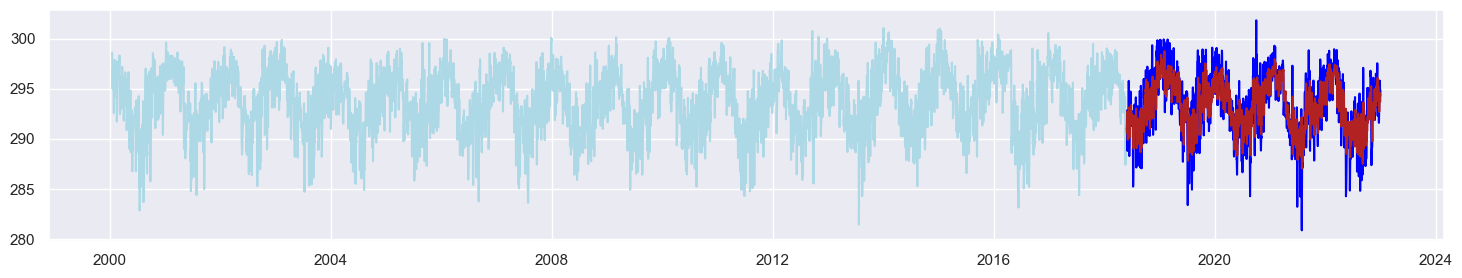

In [103]:
figure = plt.figure(figsize=(18,3))
plt.plot(train_series, c='lightblue')
plt.plot(test_series, c='blue')
plt.plot(predictions_series, c='firebrick')
plt.show()

In [104]:
train_series = pandas.DataFrame(zip(monthly_data['train']['timestamp'], monthly_data['train']['target']), columns=['time', 'temperature']).set_index('time')
test_series = pandas.DataFrame(zip(monthly_data['val']['timestamp'], monthly_data['val']['target']), columns=['time', 'temperature']).set_index('time')
predictions_series = pandas.DataFrame(zip(monthly_data['val']['timestamp'], monthly_predictions), columns=['time', 'temperature']).set_index('time')

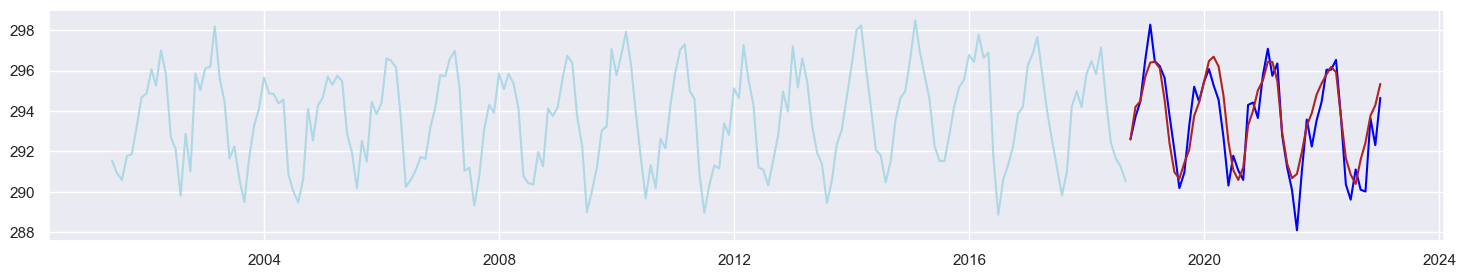

In [105]:
figure = plt.figure(figsize=(18,3))
plt.plot(train_series, c='lightblue')
plt.plot(test_series, c='blue')
plt.plot(predictions_series, c='firebrick')
plt.show()

### **Dados do El Niño**

Utilizar modelos de Série Temporal multi-variado para agregar as informações da série temporal da cidade e a série temporal histórica do El Niño, para prever a temperatura de cada cidade.

- pegar os dados do el nino
- utilizar o skforecast com os dados de sp + el nino
- verificar se o predict é melhor do que com apenas os dados da temperatura da cidade

In [46]:
coordinates = [-3, 100, 2, 120]
fetch_cdsapi_data(coordinates=coordinates, time=time, years=years, months=months, days=days, filename='el_nino.grib')

2023-11-26 12:59:58,687 INFO Welcome to the CDS
2023-11-26 12:59:58,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-26 12:59:59,029 INFO Request is queued
2023-11-26 13:00:00,272 INFO Request is running
2023-11-26 13:32:37,164 INFO Request is completed
2023-11-26 13:32:37,171 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data4/adaptor.mars.internal-1701014400.0957124-31877-3-f9cb23e6-72ca-46d0-9ce1-93a5b6a1dd2e.grib to el_nino.grib (173.1M)
2023-11-26 13:39:05,918 INFO Download rate 455.8K/s  


Para agregar features referentes ao El Niño, iremos processar da mesma forma os dados referentes ao el nino, criando um conjunto de dados de treino e validação, para dados diários e mensais de temperatura. Em seguida, criaremos um dataset composto de dados diários de temperatura com lag de 15 timestamps, e outro referente a dados mensais de temperatura, com lag de 15 timestamps.

In [107]:
ds = xr.open_dataset('./data/el_nino.grib', engine='cfgrib')

In [108]:
el_nino_daily = dataset_pre_processing(ds, group_type='1D')
el_nino_monthly = dataset_pre_processing(ds, group_type='1M')

In [109]:
el_nino_daily_dataset = create_dataset(el_nino_daily.reset_index(), lag=15, validation_split=0.2)
el_nino_monthly_dataset = create_dataset(el_nino_monthly.reset_index(), lag=15, validation_split=0.2)

Agregaremos as features simplesmente a partir da concatenação do vetor de temperatura da região com a temperatura histórica da região do El Niño. 

In [110]:
def create_joint_dataset(train_data: numpy.array, test_data: numpy.array, el_nino_train: numpy.array, el_nino_test: numpy.array):
    train_data_joined = numpy.append(train_data, el_nino_train, axis=1)
    val_data_joined = numpy.append(test_data, el_nino_test, axis=1)

    return train_data_joined, val_data_joined

In [111]:
daily_train_data_joined, daily_val_data_joined = create_joint_dataset(daily_data['train']['time_series'], daily_data['val']['time_series'], 
                                                          el_nino_daily_dataset['train']['time_series'], el_nino_daily_dataset['val']['time_series'])

monthly_train_data_joined, monthly_val_data_joined = create_joint_dataset(monthly_data['train']['time_series'], monthly_data['val']['time_series'], 
                                                          el_nino_monthly_dataset['train']['time_series'], el_nino_monthly_dataset['val']['time_series'])

In [112]:
rf = RandomForestRegressor(max_depth=10, n_estimators=500)
knn = KNeighborsRegressor(n_neighbors=12)

In [113]:
rf.fit(daily_train_data_joined, daily_data['train']['target'])
knn.fit(monthly_train_data_joined, monthly_data['train']['target'])

KNeighborsRegressor(n_neighbors=12)

In [114]:
daily_predictions = rf.predict(daily_val_data_joined)
monthly_predictions = knn.predict(monthly_val_data_joined)

In [115]:
print(f'Daily predictions r2 score: {r2_score(daily_data['val']['target'], daily_predictions)}\nMonthly predictions r2 score: {r2_score(monthly_data['val']['target'], monthly_predictions)}')

Daily predictions r2 score: 0.5634703480180047
Monthly predictions r2 score: 0.7892051914163442


R2 Score utilizando dados somente da temperatura da região:
- Daily predictions r2 score: 0.5286337542539554
- Monthly predictions r2 score: 0.7634659292145901

R2 Score utilizando dados conjuntos, da temperatura da região e do El Niño:
- Daily predictions r2 score: 0.5265443968921979
- Monthly predictions r2 score: 0.7788867636537699

In [116]:
train_series = pandas.DataFrame(zip(daily_data['train']['timestamp'], daily_data['train']['target']), columns=['time', 'temperature']).set_index('time')
test_series = pandas.DataFrame(zip(daily_data['val']['timestamp'], daily_data['val']['target']), columns=['time', 'temperature']).set_index('time')
predictions_series = pandas.DataFrame(zip(daily_data['val']['timestamp'], daily_predictions), columns=['time', 'temperature']).set_index('time')

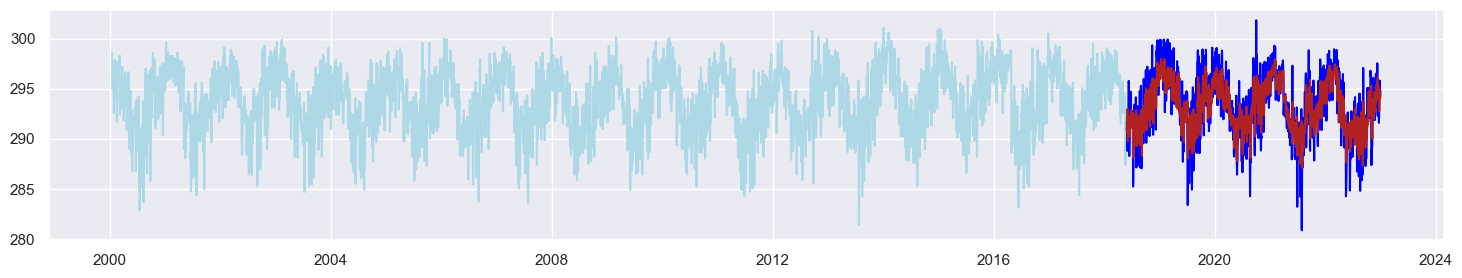

In [117]:
figure = plt.figure(figsize=(18,3))
plt.plot(train_series, c='lightblue')
plt.plot(test_series, c='blue')
plt.plot(predictions_series, c='firebrick')
plt.show()

In [118]:
train_series = pandas.DataFrame(zip(monthly_data['train']['timestamp'], monthly_data['train']['target']), columns=['time', 'temperature']).set_index('time')
test_series = pandas.DataFrame(zip(monthly_data['val']['timestamp'], monthly_data['val']['target']), columns=['time', 'temperature']).set_index('time')
predictions_series = pandas.DataFrame(zip(monthly_data['val']['timestamp'], monthly_predictions), columns=['time', 'temperature']).set_index('time')

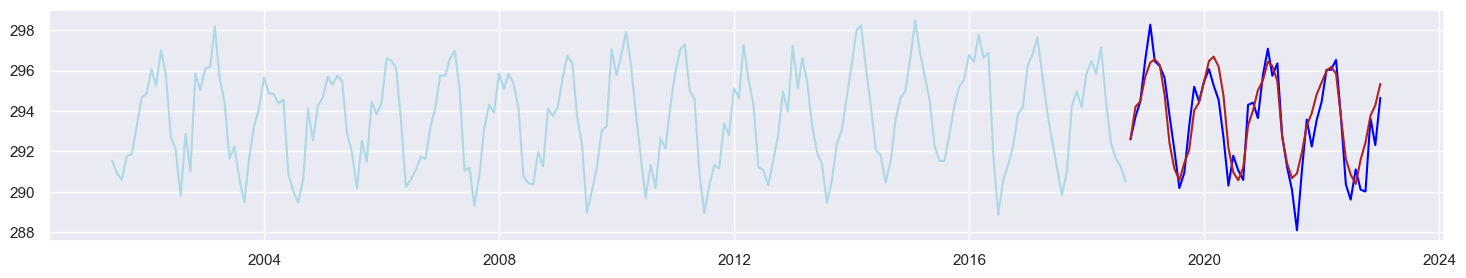

In [119]:
figure = plt.figure(figsize=(18,3))
plt.plot(train_series, c='lightblue')
plt.plot(test_series, c='blue')
plt.plot(predictions_series, c='firebrick')
plt.show()

## **Análise das cidades brasileiras**

Temos os dois modelos considerados para a análise da série temporal. Obtivemos uma conclusão inicial de que o El Niño incrementa as features da série, permitindo uma melhor precisão na predição da temperatura. Iremos expandir nossa análise para as demais cidades brasileiras consideradas neste estudo, utilizando os modelos construídos anteriormente, para quantificar de certa forma, a influência do fenômeno nas diferentes cidades. 

In [11]:
def predict_dataset(daily_train_X: numpy.array, daily_train_y: numpy.array, 
                    monthly_train_X: numpy.array, monthly_train_y: numpy.array,
                    daily_val_X: numpy.array, monthly_val_X: numpy.array) -> tuple[numpy.array, numpy.array]:
    
    rf = RandomForestRegressor(n_estimators=500, max_depth=10)
    knn = KNeighborsRegressor(n_neighbors=12)

    rf.fit(daily_train_X, daily_train_y)
    knn.fit(monthly_train_X, monthly_train_y)

    return rf.predict(daily_val_X), knn.predict(monthly_val_X)

In [33]:
def process_city_dataframe(city: str, el_nino_daily_dataset: dict, el_nino_monthly_dataset: dict) -> dict:
    city_filepath = f'./data/{city}.grib'

    dataset = xr.open_dataset(city_filepath, engine='cfgrib')
    daily_dataset = dataset_pre_processing(dataset, group_type='1D')
    monthly_dataset = dataset_pre_processing(dataset, group_type='1M')
    
    daily_lagged_dataset = create_dataset(daily_dataset.reset_index(), lag=15, validation_split=0.2)
    monthly_lagged_dataset = create_dataset(monthly_dataset.reset_index(), lag=15, validation_split=0.2)

    univariate_daily_pred, univariate_monthly_pred = predict_dataset(daily_lagged_dataset['train']['time_series'], daily_lagged_dataset['train']['target'],
                                                                     monthly_lagged_dataset['train']['time_series'], monthly_lagged_dataset['train']['target'],
                                                                     daily_lagged_dataset['val']['time_series'], monthly_lagged_dataset['val']['time_series'])
    
    combined_daily_dataset_train, combined_daily_dataset_test = create_joint_dataset(daily_lagged_dataset['train']['time_series'], daily_lagged_dataset['val']['time_series'], 
                                                                                     el_nino_daily_dataset['train']['time_series'], el_nino_daily_dataset['val']['time_series'])

    combined_monthly_dataset_train, combined_monthly_dataset_test = create_joint_dataset(monthly_lagged_dataset['train']['time_series'], monthly_lagged_dataset['val']['time_series'], 
                                                                                         el_nino_monthly_dataset['train']['time_series'], el_nino_monthly_dataset['val']['time_series'])
    
    combined_daily_pred, combined_monthly_pred = predict_dataset(combined_daily_dataset_train, daily_lagged_dataset['train']['target'],
                                                                 combined_monthly_dataset_train, monthly_lagged_dataset['train']['target'],
                                                                 combined_daily_dataset_test, combined_monthly_dataset_test)
    
    return {
        'daily': {
            'univariate': univariate_daily_pred,
            'combined': combined_daily_pred,
            'target': daily_lagged_dataset['val']['target'],
            'timestamp': daily_lagged_dataset['val']['timestamp']
        }, 
        'monthly': {
            'univariate': univariate_monthly_pred,
            'combined': combined_monthly_pred,
            'target': monthly_lagged_dataset['val']['target'],
            'timestamp': monthly_lagged_dataset['val']['timestamp']
        }
    }

In [34]:
cities = ['brasilia', 'campo_grande', 'joao_pessoa', 'macapa', 'manaus', 'porto_alegre', 'rio_de_janeiro', 'salvador', 'sao_paulo']

results = {}
for city in tqdm.tqdm(cities):
    results[city] = process_city_dataframe(city, el_nino_daily_dataset, el_nino_monthly_dataset)

100%|██████████| 9/9 [44:05<00:00, 293.97s/it]


In [35]:
import pickle

with open('resultado.p', 'wb') as f:
    pickle.dump(results, f)

In [121]:
def create_plot_and_r2_score_comparation(result_dict: dict):
    univariate_r2 = r2_score(result_dict['target'], result_dict['univariate'])
    combined_r2 = r2_score(result_dict['target'], result_dict['combined'])

    print(f'R2 comparation: \n\tUnivariate: {univariate_r2}\n\tCombined: {combined_r2}\n\tDifference: {combined_r2 - univariate_r2}')

    true_series = pandas.DataFrame(zip(result_dict['timestamp'], result_dict['target']), columns=['time', 'temperature']).set_index('time')
    univariate_series = pandas.DataFrame(zip(result_dict['timestamp'], result_dict['univariate']), columns=['time', 'temperature']).set_index('time')
    combined_series = pandas.DataFrame(zip(result_dict['timestamp'], result_dict['combined']), columns=['time', 'temperature']).set_index('time')

    figure = plt.figure(figsize=(18,3))
    plt.plot(true_series, c='lightblue', label='true')
    plt.plot(univariate_series, c='blue', label='univariate')
    plt.plot(combined_series, c='lightgreen', label='combined')
    plt.legend()
    plt.show()

Data for city brasilia
Daily results
R2 comparation: 
	Univariate: 0.6293404373010847
	Combined: 0.6297177292301961
	Difference: 0.00037729192911140075


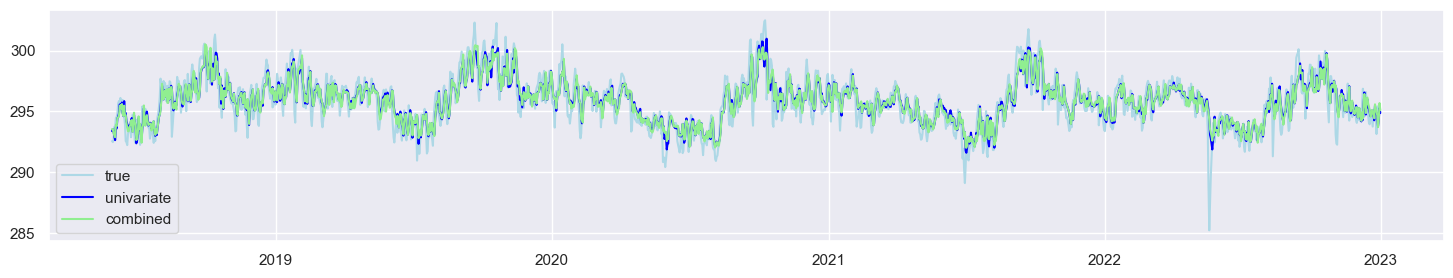

Monthly results
R2 comparation: 
	Univariate: 0.7339637949874709
	Combined: 0.747101776037878
	Difference: 0.013137981050407088


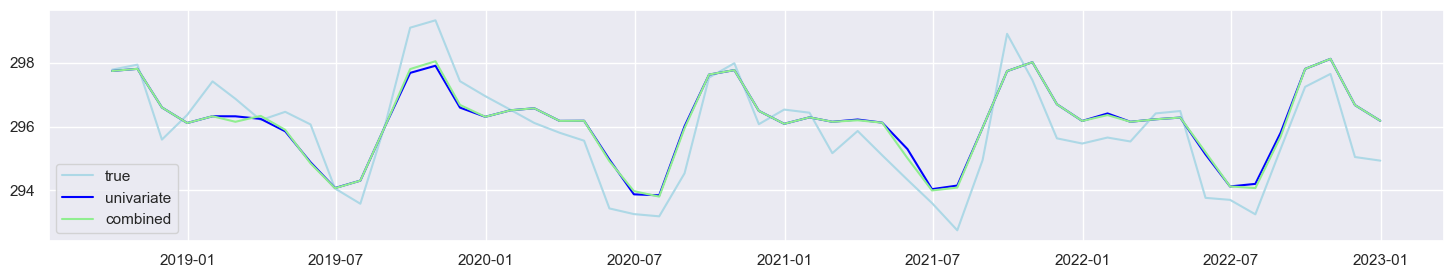

Data for city campo_grande
Daily results
R2 comparation: 
	Univariate: 0.43528889316936203
	Combined: 0.43571234651351376
	Difference: 0.0004234533441517252


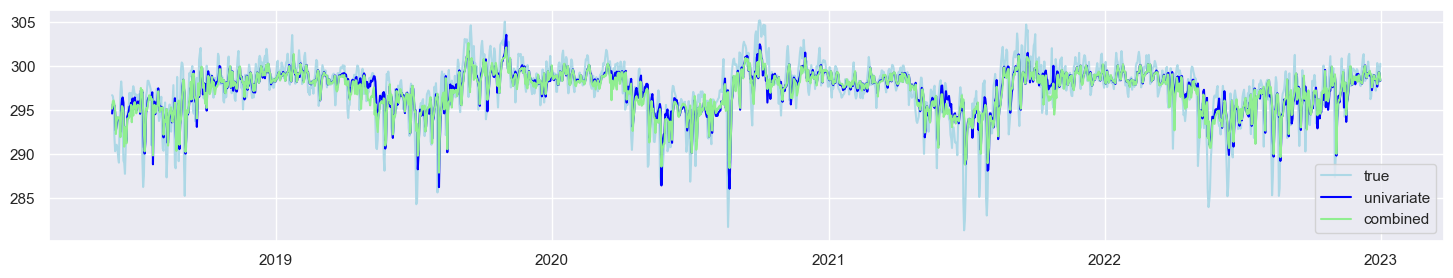

Monthly results
R2 comparation: 
	Univariate: 0.6964167853319001
	Combined: 0.7032764514704586
	Difference: 0.0068596661385584845


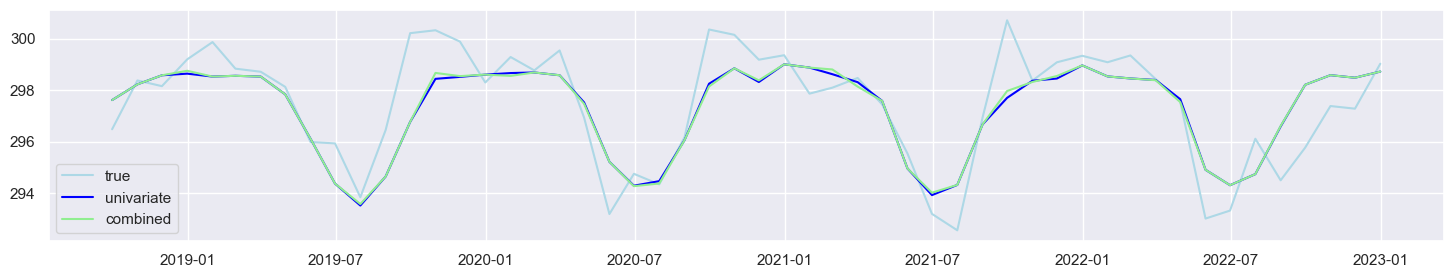

Data for city joao_pessoa
Daily results
R2 comparation: 
	Univariate: 0.7811534577818541
	Combined: 0.7804972894563168
	Difference: -0.0006561683255372763


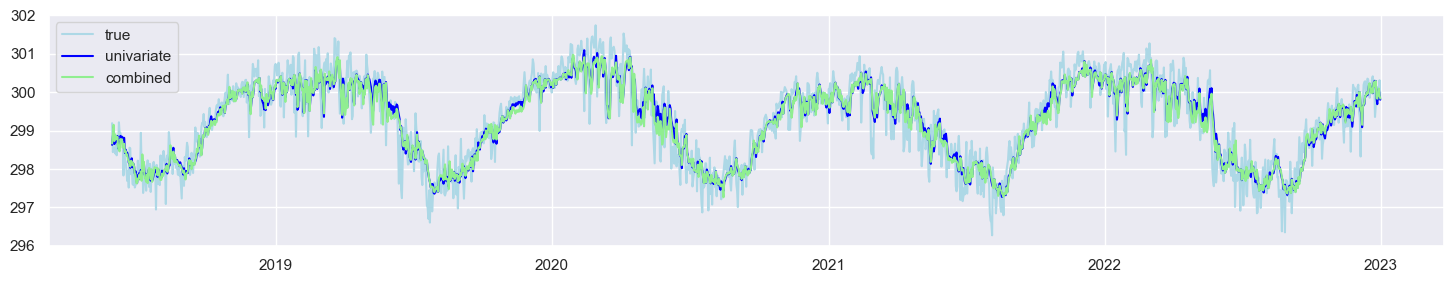

Monthly results
R2 comparation: 
	Univariate: 0.8490555895137457
	Combined: 0.850861151553077
	Difference: 0.0018055620393312433


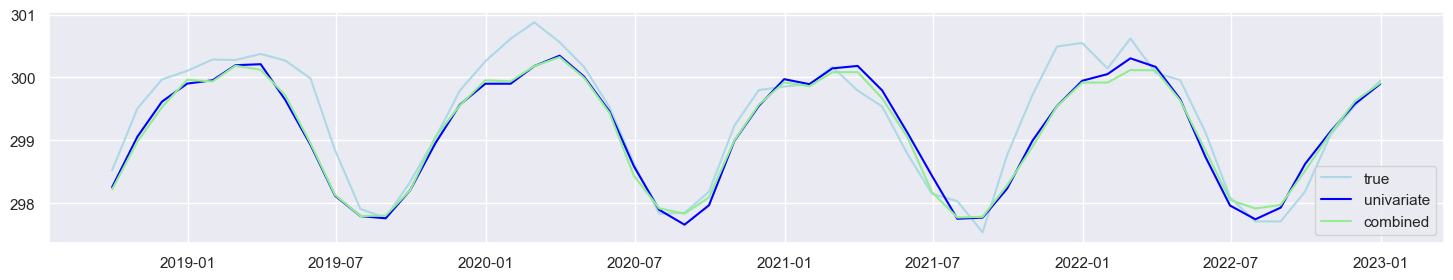

Data for city macapa
Daily results
R2 comparation: 
	Univariate: 0.6938954971596527
	Combined: 0.6992496503238239
	Difference: 0.005354153164171205


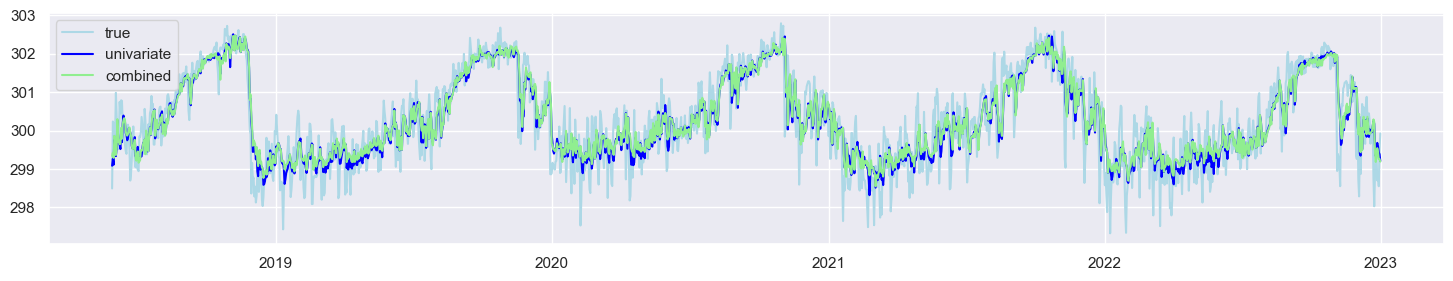

Monthly results
R2 comparation: 
	Univariate: 0.8347102114776151
	Combined: 0.8377760122054174
	Difference: 0.0030658007278022703


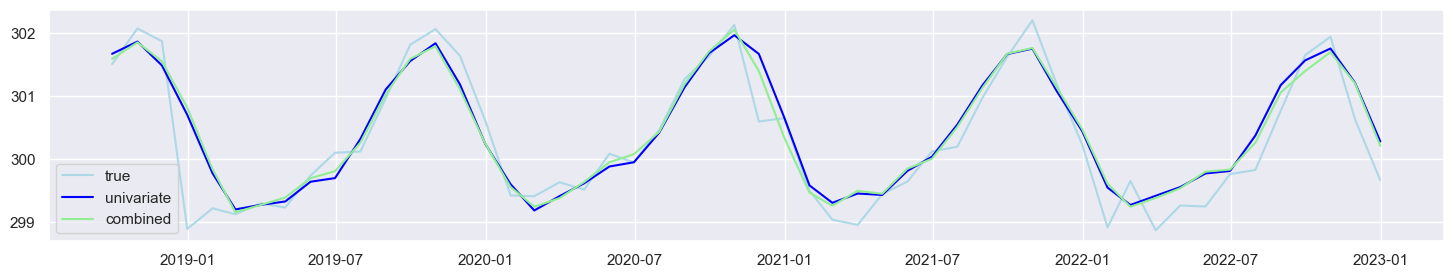

Data for city manaus
Daily results
R2 comparation: 
	Univariate: 0.37737757689493623
	Combined: 0.3781918234722651
	Difference: 0.0008142465773288698


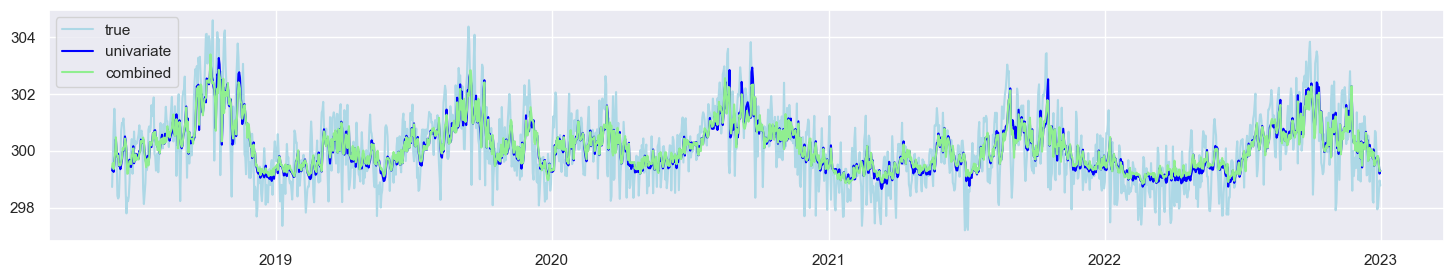

Monthly results
R2 comparation: 
	Univariate: 0.5584640934710923
	Combined: 0.5945163929157659
	Difference: 0.036052299444673586


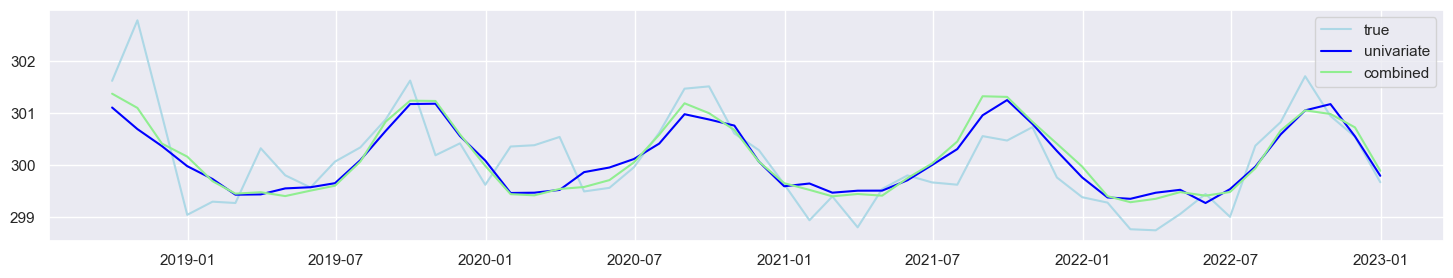

Data for city porto_alegre
Daily results
R2 comparation: 
	Univariate: 0.6600065683604972
	Combined: 0.6647498673139616
	Difference: 0.00474329895346437


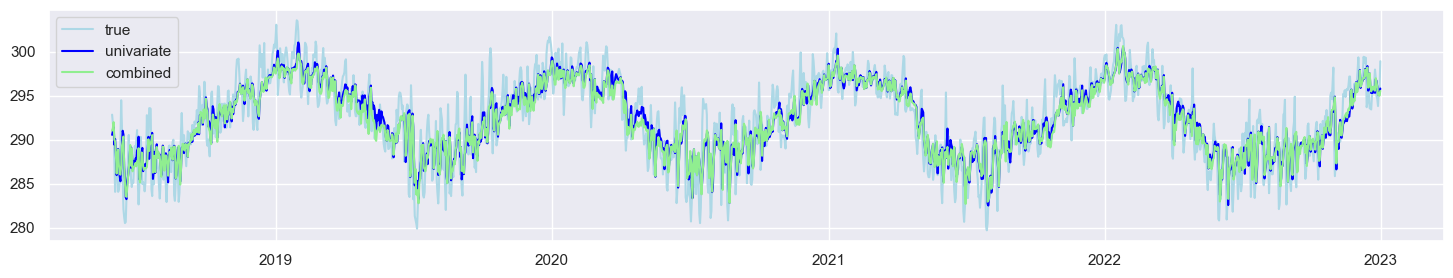

Monthly results
R2 comparation: 
	Univariate: 0.9092619677574164
	Combined: 0.910686563509002
	Difference: 0.0014245957515856


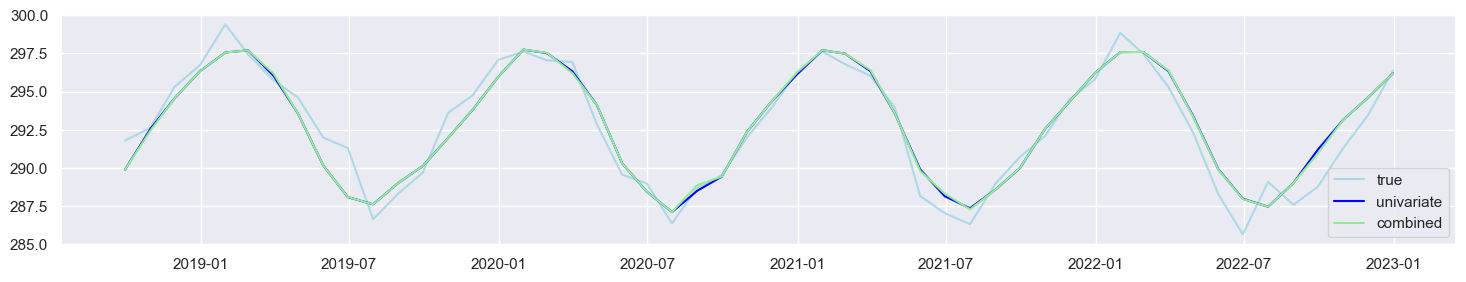

Data for city rio_de_janeiro
Daily results
R2 comparation: 
	Univariate: 0.6421238239962818
	Combined: 0.6369249151148983
	Difference: -0.005198908881383413


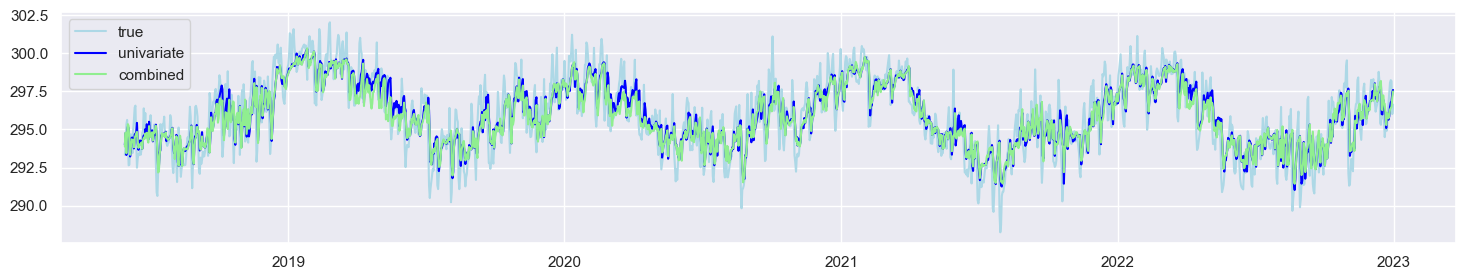

Monthly results
R2 comparation: 
	Univariate: 0.7624222455970766
	Combined: 0.7821128765018188
	Difference: 0.019690630904742212


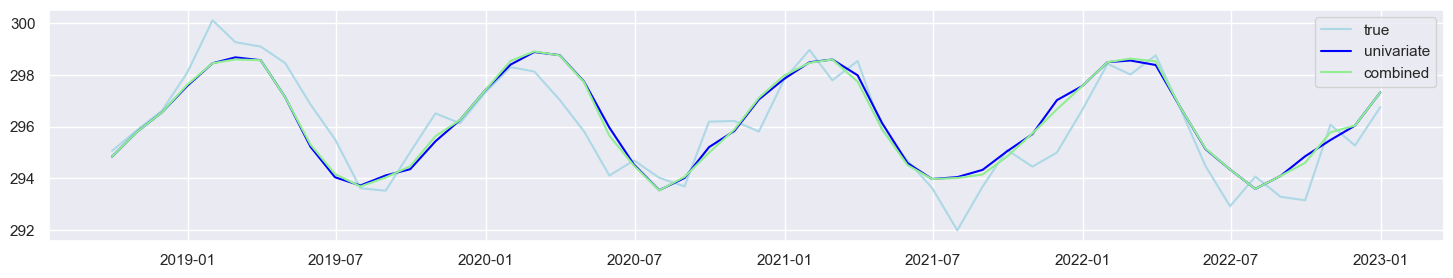

Data for city salvador
Daily results
R2 comparation: 
	Univariate: 0.7655686699835034
	Combined: 0.7665979167303307
	Difference: 0.0010292467468273614


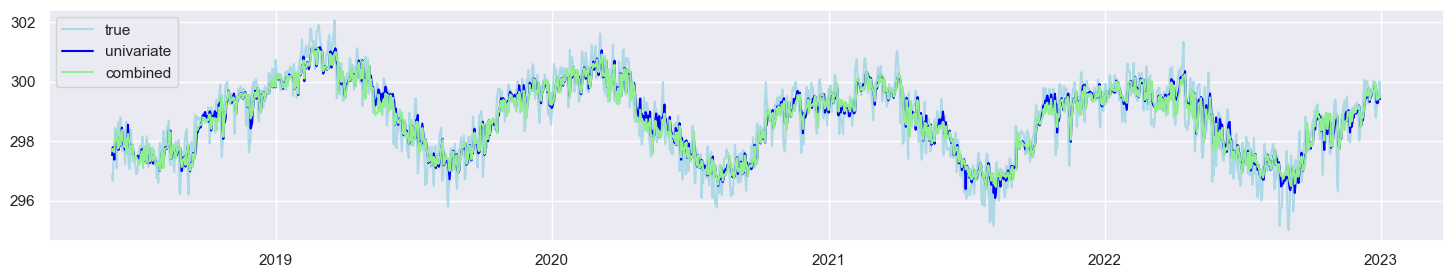

Monthly results
R2 comparation: 
	Univariate: 0.8507445674404985
	Combined: 0.8561052047090151
	Difference: 0.005360637268516544


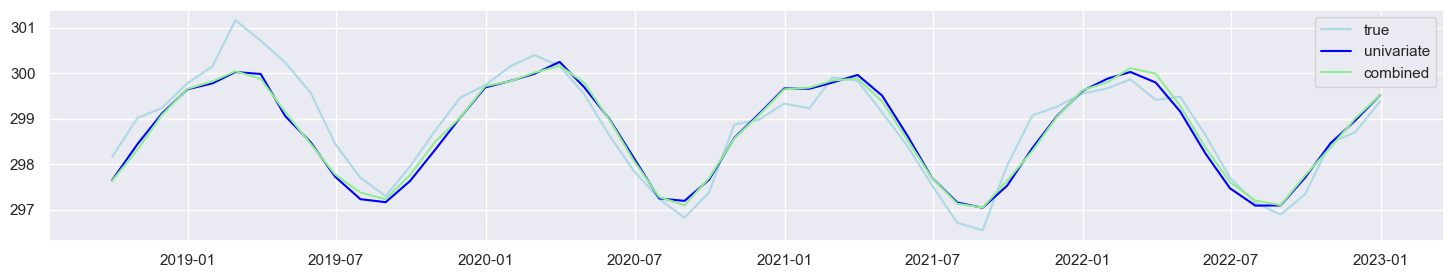

Data for city sao_paulo
Daily results
R2 comparation: 
	Univariate: 0.5639200807730647
	Combined: 0.5631192388989161
	Difference: -0.0008008418741485279


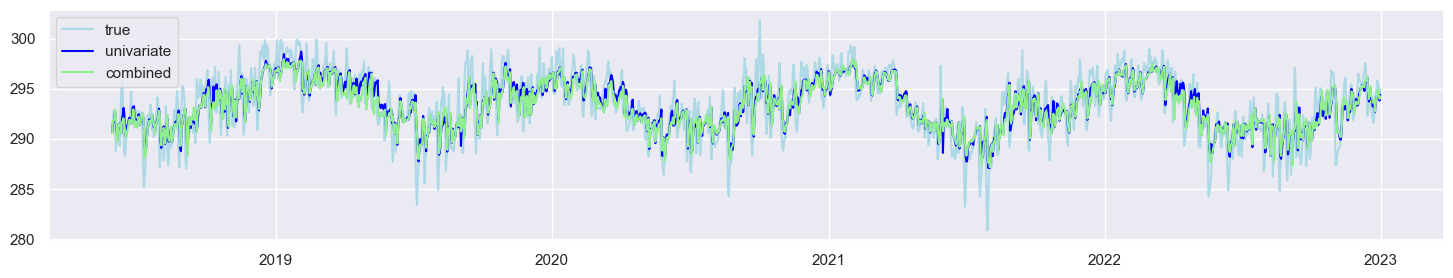

Monthly results
R2 comparation: 
	Univariate: 0.7796426212031472
	Combined: 0.7892051914163442
	Difference: 0.009562570213196953


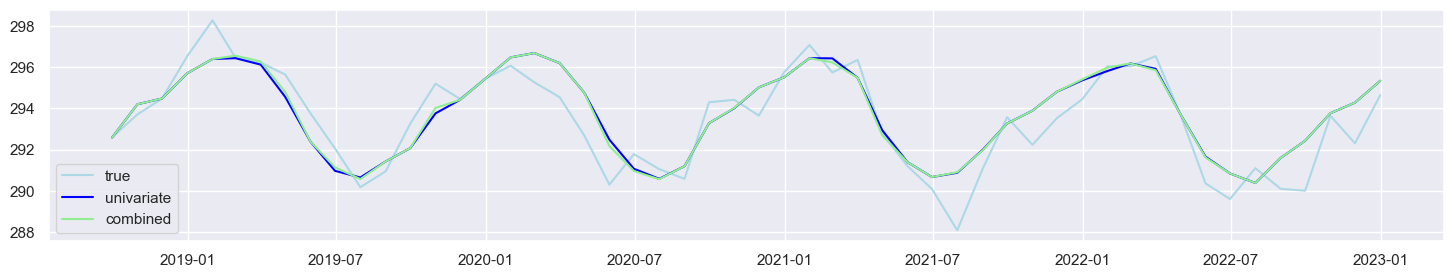

In [122]:
for city, result in results.items():
    print(f'Data for city {city}')
    print('Daily results')
    create_plot_and_r2_score_comparation(result['daily'])

    print('Monthly results')
    create_plot_and_r2_score_comparation(result['monthly'])


## **Conclusões**

Podemos observar um impacto majoritariamente positivo (aumento da métrica R2 Score) na predição de temperatura das cidades quando se é agregada a informação de temperatura do El Niño. Assim, utilizar os dados históricos do El Niño é possível fonte de dados para a predição da temperatura de cidades brasileiras.

Ainda, é possível rankear as cidades em que a previsão da temperatura foi impactada mais positivamente pelo utilização dessa outra série temporal, permitindo um estudo sobre quais são as cidades brasileiras que mais sofrem impacto do fenômeno El Niño. 